In [1]:
from chapter1 import *
from scipy.optimize import minimize
from scipy.sparse.linalg import gmres
from scipy.linalg import polar
from functools import partial
from time import time
import matplotlib.pyplot as plt

# Tangent-space methods for uniform matrix product states

https://arxiv.org/abs/1810.07006

## 2. Finding ground states of local Hamiltonians

Having found a way of encoding the states, the next step is to implement a way of finding the ground state. To this end, we consider a nearest-neighbour Hamiltonian H, of the form
$$H = \sum_n h_{n, n+1}.$$
Here $h_{n,n+1}$ is a hermitian operator acting non-trivially on the sites $n$ and $n+1$. As in any variational approach, the variational principle serves as a guide for finding ground-state approximations, we want to minimise the expectation value of the energy,
$$ \min_A \frac{<\Psi(\bar{A})| H | \Psi(A) >}{<\Psi(\bar{A})|\Psi(A)>}. $$

In the thermodynamic limit the energy diverges with system size, but, since we are working with translation-invariant states only, we should rather minimise the energy density. We also will restrict to properly normalised states. Diagrammatically, the minimization problem is recast as

![minDiagram](img/2minham.png)

We now turn to some numerical optimization strategies for minimizing this energy density directly.

### 2.1 The gradient

Any optimization problem relies on an efficient evaluation of the gradient, so the first thing to do is to compute this quantity (efficiently). The objective function $f$ that we want to minimize is a real function of the complex-valued $A$, or equivalently, the independent variables $A$ and $\bar{A}$. The gradient $g$ is then obtained by differentiating $f(\bar{A},A)$ with respect to $\bar{A}$,

![gradCalc](img/gradientCalc.png)

If we make sure that the MPS is properly normalised, and subtract the current energy density from every term in the hamiltonian, the gradient takes on the simple form
$$ g = 2 \partial_\bar{A} <\Psi(\bar{A})| h | \Psi(A) >.$$

Thus, the gradient is obtained by differentiating the expression

![grad2](img/grad2.png)

with respect to $\bar{A}$. Differentiating with respect to one $\bar{A}$ tensor amounts to leaving out that tensor, and interpreting the open legs as outgoing ones, i.e. each term looks like

![gradTerms](img/gradTerms.png)

#### Terms of the 'center' kind
The first kind of terms that arise in the above expression for the gradient are obtained by removing one of the $\bar{A}$ on the legs of the Hamiltonian term. This leads to

![gradTerms](img/centerTerms.png)

In [2]:
def gradCenterTerms(hTilde, A, l=None, r=None):
    """
    Calculate the value of the center terms.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight.
        A : np.array (D, d, D)
            normalised MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        
        Returns
        -------
        term1 : np.array(D, d, D)
            first term of gradient,
            ordered left-mid-right.
        term2 : np.array(D, d, D)
            second term of gradient,
            ordered left-mid-right.
    """
    
    # calculate fixed points if not supplied
    if l is None or r is None:
        l, r = fixedPoints(A)
        
    # calculate first contraction
    term1 = ncon((l, r, A, A, np.conj(A), hTilde), ([-1, 1], [5, 7], [1, 3, 2], [2, 4, 5], [-3, 6, 7], [3, 4, -2, 6]))
    
    # calculate second contraction
    term2 = ncon((l, r, A, A, np.conj(A), hTilde), ([6, 1], [5, -3], [1, 3, 2], [2, 4, 5], [6, 7, -1], [3, 4, 7, -2]))
    
    return term1, term2

#### Terms of the 'left' kind
For the terms where we omit an $\bar{A}$ tensor to the left of the operator $h$, we can contract everything to the left of this missing $\bar{A}$ tensor with the fixed point $l$, and everything to the right of the site containing the Hamiltonian is contracted with $r$.

In between these two parts of the network, there is $E^n$, the transfermatrix multiplied $n$ times where $n$ is the separation between the two regions. Thus, summing all terms of the 'left' kind together means that we sum over $n$, and the relevant tensor becomes

$$E_\text{sum} = 1 + E + E^2 + \dots = \frac{1}{1-E}.$$

However, we must be careful when doing this, as the transfer matrix has leading eigenvalue $1$ (as defined by our normalization), this quantity will diverge. This can be solved by defining a regularized transfer matrix $\tilde{E}$, substracting the divergent part:

![regTransfer](img/regTransfer.png)

and only then taking the inverse.

$$ \tilde{E}_\text{sum} = \frac{1}{1-\tilde{E}} =: (1 - E)^p $$

To ensure that this substraction has no effect on the outcome, we will redefine the Hamiltonian to have expectation value $0$. Such a constant shift in energy has no effect when we calculate the gradient. The benefit is that the divergent part we substracted from the transfermatrix vanishes.

$$ \tilde{H} = H - e $$

Using this, we define the partial contraction

![Rh](img/Rh.png)

such that the sum of all left terms equals

![leftTerms](img/leftTerm.png)

Implementing this inverse naively would be an ill-defined problem, so we resort to other algorithms to find $R_h$. Multiplying both sides with $(1-\tilde{E})$ results in an equation of the form $Ax = b$, which may be solved for $x$ by implementing a Generalized Minimal RESidual (GMRES) algorithm. 

Note that again such an algorithm requires only the action of A on a vector, not the actual matrix, such that its construction should again be implemented using a function handle.

In [3]:
def reducedHamUniform(h, A, l=None, r=None):
    """
    Regularise Hamiltonian such that its expectation value is 0.
    
        Parameters
        ----------
        h : np.array (d, d, d, d)
            Hamiltonian that needs to be reduced,
            ordered topLeft-topRight-bottomLeft-bottomRight.
        A : np.array (D, d, D)
            normalised MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
            
        Returns
        -------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight.
    """
    
    d = A.shape[1]
    
    # calculate fixed points if not supplied
    if l is None or r is None:
        l, r = fixedPoints(A)
    
    # calculate expectation value
    e = np.real(expVal2Uniform(h, A, l, r))
    
    # substract from hamiltonian
    hTilde = h - e * ncon((np.eye(d), np.eye(d)), ([-1, -3], [-2, -4]))
    
    return hTilde

In [4]:
def EtildeRight(A, l, r, v):
    """
    Implement the action of (1 - Etilde) on a right vector v.
    
        Parameters
        ----------
        A : np.array (D, d, D)
            normalised MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        v : np.array(D**2)
            right matrix of size (D, D) on which
            (1 - Etilde) acts,
            given as a vector of size (D**2,)
        
        Returns
        -------
        vNew : np.array(D**2)
            result of action of (1 - Etilde)
            on a right matrix,
            given as a vector of size (D**2,)
    """
    
    D = A.shape[0]
    
    # reshape to matrix
    v = v.reshape(D, D)
        
    # transfermatrix contribution
    transfer = ncon((A, np.conj(A), v), ([-1, 2, 1], [-2, 2, 3], [1, 3]))

    # fixed point contribution
    fixed = np.trace(l @ v) * r

    # sum these with the contribution of the identity
    vNew = v - transfer + fixed

    return vNew.reshape((D ** 2))

In [5]:
def RhUniform(hTilde, A, l=None, r=None):
    """
    Find the partial contraction for Rh.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        A : np.array (D, d, D)
            normalised MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        
        Returns
        -------
        Rh : np.array(D, D)
            result of contraction,
            ordered top-bottom.
    """
    
    D = A.shape[0]
    
    # if l, r not specified, find fixed points
    if l is None or r is None:
        l, r = fixedPoints(A)
    
    # construct b, which is the matrix to the right of (1 - E)^P in the figure above
    b = ncon((r, A, A, np.conj(A), np.conj(A), hTilde), ([4, 5], [-1, 2, 1], [1, 3, 4], [-2, 8, 7], [7, 6, 5], [2, 3, 8, 6]))
    
    # solve Ax = b for x
    A = LinearOperator((D ** 2, D ** 2), matvec=partial(EtildeRight, A, l, r))
    Rh = gmres(A, b.reshape(D ** 2))[0]
    
    return Rh.reshape((D, D))

In [6]:
def gradLeftTerms(hTilde, A, l=None, r=None):
    """
    Calculate the value of the left terms.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        A : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        
        Returns
        -------
        leftTerms : np.array(D, d, D)
            left terms of gradient,
            ordered left-mid-right.
    """
    
    # if l, r not specified, find fixed points
    if l is None or r is None:
        l, r = fixedPoints(A)
    
    # calculate partial contraction
    Rh = RhUniform(hTilde, A, l, r)
    
    # calculate full contraction
    leftTerms = ncon((Rh, A, l), ([1, -3], [2, -2, 1], [-1, 2]))
    
    return leftTerms

#### Terms of the 'right' kind
In a very similar way, the terms where we leave out an $\bar{A}$ to the right of the operator $h$, can be evaluated with the following contractions:

![Lh](img/Lh.png)

such that the sum of all 'right' terms equals

![rightTerms](img/rightTerm.png)

In [7]:
def EtildeLeft(A, l, r, v):
    """
    Implement the action of (1 - Etilde) on a left vector matrix v.
    
        Parameters
        ----------
        A : np.array (D, d, D)
            normalised MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        v : np.array(D**2)
            right matrix of size (D, D) on which
            (1 - Etilde) acts,
            given as a vector of size (D**2,)
        
        Returns
        -------
        vNew : np.array(D**2)
            result of action of (1 - Etilde)
            on a left matrix,
            given as a vector of size (D**2,)
    """
    
    D = A.shape[0]
    
    # reshape to matrix
    v = v.reshape(D, D)

    # transfer matrix contribution
    transfer = ncon((v, A, np.conj(A)), ([3, 1], [1, 2, -2], [3, 2, -1]))

    # fixed point contribution
    fixed = np.trace(v @ r) * l

    # sum these with the contribution of the identity
    vNew = v - transfer + fixed

    return vNew.reshape((D ** 2))

In [8]:
def LhUniform(hTilde, A, l=None, r=None):
    """
    Find the partial contraction for Lh.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        A : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        
        Returns
        -------
        Lh : np.array(D, D)
            result of contraction,
            ordered bottom-top.
    """
    
    D = A.shape[0]
    
    # if l, r not specified, find fixed points
    if l is None or r is None:
        l, r = fixedPoints(A)
    
    # construct b, which is the matrix to the right of (1 - E)^P in the figure above
    b = ncon((l, A, A, np.conj(A), np.conj(A), hTilde), ([5, 1], [1, 3, 2], [2, 4, -2], [5, 6, 7], [7, 8, -1], [3, 4, 6, 8]))    
    
    # solve Ax = b for x
    A = LinearOperator((D ** 2, D ** 2), matvec=partial(EtildeLeft, A, l, r)) 
    Lh = gmres(A, b.reshape(D ** 2))[0]
    
    return Lh.reshape((D, D))

In [9]:
def gradRightTerms(hTilde, A, l=None, r=None):
    """
    Calculate the value of the right terms.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        A : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        
        Returns
        -------
        rightTerms : np.array(D, d, D)
            right terms of gradient,
            ordered left-mid-right.
    """
    
    # if l, r not specified, find fixed points
    if l is None or r is None:
        l, r = fixedPoints(A)
    
    # calculate partial contraction
    Lh = LhUniform(hTilde, A, l, r)
    
    # calculate full contraction
    rightTerms = ncon((Lh, A, r), ([-1, 1], [1, -2, 2], [2, -3]))
    
    return rightTerms

The gradient is then found by summing all these contributions:

![gradient](img/gradient.png)

In [10]:
def gradient(h, A, l=None, r=None):
    """
    Calculate the gradient of the expectation value of h @ MPS A.
    
        Parameters
        ----------
        h : np.array (d, d, d, d)
            Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        A : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right.
        l : np.array(D, D), optional
            left fixed point of transfermatrix,
            normalised.
        r : np.array(D, D), optional
            right fixed point of transfermatrix,
            normalised.
        
        Returns
        -------
        grad : np.array(D, d, D)
            Gradient,
            ordered left-mid-right.
    """
    
    # if l, r not specified, find fixed points
    if l is None or r is None:
        l, r = fixedPoints(A)
        
    # renormalise Hamiltonian
    hTilde = reducedHamUniform(h, A, l, r)
        
    # find terms
    centerTerm1, centerTerm2 = gradCenterTerms(hTilde, A, l, r)
    leftTerms = gradLeftTerms(hTilde, A, l, r)
    rightTerms = gradRightTerms(hTilde, A, l, r)
    
    grad = 2 * (centerTerm1 + centerTerm2 + leftTerms + rightTerms)
    
    return grad

### 2.2 Gradient descent algorithms
The simplest way to use this information to find the ground state of a Hamiltonian is then to use a method of gradient descent, or just by iterating, for a small step $\epsilon$,

$$ A_{i+1} = A_i - \epsilon g $$

in order to find the optimal MPS tensor $A^*$ for which the gradient vanishes. However, this can be further improved upon by using more advanced algorithms, as for example those already implemented by the scipy package scipy.optimize.

In [11]:
def groundStateGradDescent(h, D, eps=1e-1, A0=None, tol=1e-4, maxIter=1e4):
    """
    Find the ground state using gradient descent.
    
        Parameters
        ----------
        h : np.array (d, d, d, d)
            Hamiltonian to minimise,
            ordered topLeft-topRight-bottomLeft-bottomRight.
        D : int
            Bond dimension
        eps : float
            Stepsize.
        A0 : np.array (D, d, D)
            normalised MPS tensor with 3 legs,
            ordered left-bottom-right,
            initial guess.
        tol : float
            Tolerance for convergence criterium.
        
        Returns
        -------
        E : float
            expectation value @ minimum
        A : np.array(D, d, D)
            ground state MPS,
            ordered left-mid-right.
    """
    
    d = h.shape[0]
    
    # if no initial value, choose random
    if A0 is None:
        A0 = createMPS(D, d, D)
        A0 = normaliseMPS(A0)
    
    # calculate gradient
    g = gradient(h, A0)
    g0 = np.zeros((D, d, D))
    
    A = A0
    
    i = 0
    while not(np.all(np.abs(g) < tol)):
        # do a step
        A = A - eps * g
        A = normaliseMPS(A)
        i += 1
        
        if not(i % 100):
            E = np.real(expVal2Uniform(h, A))
            print('Current energy:', E)
        
        # calculate new gradient
        g = gradient(h, A)
        
        if i > maxIter:
            print('Warning: gradient descent did not converge!')
            break
    
    # calculate ground state energy
    E = np.real(expVal2Uniform(h, A))
    
    return E, A

In order to use the minimize function from scipy for this purpose, one must keep in mind the fact that minimize requires an objective function that maps a real vector to a scalar. In particular, complex tensors must be given as reals vectors in the input, and must be again represented as real vectors in the output.

In [12]:
def groundStateMinimise(h, D, A0=None, tol=1e-4):
    """
    Find the ground state using a scipy minimizer.
    
        Parameters
        ----------
        h : np.array (d, d, d, d)
            Hamiltonian to minimise,
            ordered topLeft-topRight-bottomLeft-bottomRight.
        D : int
            Bond dimension
        A0 : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            initial guess.
        tol : float
            Relative convergence criterium.
        
        Returns
        -------
        E : float
            expectation value @ minimum
        A : np.array(D, d, D)
            ground state MPS,
            ordered left-mid-right.
    """
    
    d = h.shape[0]
    
    def unwrapper(varA):
        """
        Unwraps real MPS vector to complex MPS tensor.
        
            Parameters
            ----------
            varA : np.array(2 * D * d * D)
                MPS tensor in real vector form.
            D : int
                Bond dimension.
            d : int
                Physical dimension.
                
            Returns
            -------
            A : np.array(D, d, D)
                MPS tensor with 3 legs,
                ordered left-bottom-right.
        """
        
        # unpack real and imaginary part
        Areal = varA[:D ** 2 * d]
        Aimag = varA[D ** 2 * d:]
        
        A = Areal + 1.0j * Aimag
        
        return np.reshape(A, (D, d, D))
    
    def wrapper(A):
        """
        Wraps MPS tensor to real MPS vector.
        
            Parameters
            ----------
            A : np.array(D, d, D)
                MPS tensor,
                ordered left-bottom-right
            
            Returns
            -------
            varA : np.array(2 * D * d * D)
                MPS tensor in real vector form.
        """
        
        # split into real and imaginary part
        Areal = np.real(A)
        Aimag = np.imag(A)
        
        # combine into vector
        varA = np.concatenate( (Areal.reshape(-1), Aimag.reshape(-1)) )
        
        return varA
    
    # if no initial MPS, take random one
    if A0 is None:
        A0 = createMPS(D, d)
        A0 = normaliseMPS(A0)
    
    # define f for minimize in scipy
    def f(varA):
        """
        Function to optimize via minimize.
        
            Parameters
            ----------
            varA : np.array(2 * D * d * D)
                MPS tensor in real vector form.
            
            Returns
            -------
            e : float
                function value @varA
            g : np.array(2 * D * d * D)
                gradient vector @varA
        """
        
        # unwrap varA
        A = unwrapper(varA)
        A = normaliseMPS(A)
        
        # calculate fixed points
        l, r = fixedPoints(A)
        
        # calculate function value and gradient
        e = np.real(expVal2Uniform(h, A, l, r))
        g = gradient(h, A, l, r)
        
        # wrap g
        g = wrapper(g)
        
        return e, g
    
    # calculate minimum
    result = minimize(f, wrapper(A0), jac=True, tol=tol)
    
    # unpack result
    E = result.fun
    A = unwrapper(result.x)
    
    return E, A

These methods can be tested for the specific case of the antiferromagnetic Heisenberg model. To this end we first define the spin 1 Heisenberg Hamiltonian:

In [13]:
def Heisenberg(Jx, Jy, Jz, hz):
    """
    Construct the spin-1 Heisenberg Hamiltonian for given couplings.
    
        Parameters
        ----------
        Jx : float
            Coupling strength in x direction
        Jy : float
            Coupling strength in y direction
        Jy : float
            Coupling strength in z direction
        hz : float
            Coupling for Sz terms

        Returns
        -------
        h : np.array (3, 3, 3, 3)
            Spin-1 Heisenberg Hamiltonian.
    """
    Sx = np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)
    Sy = np.array([[0, -1, 0], [1, 0, -1], [0, 1, 0]]) * 1.0j /np.sqrt(2)
    Sz = np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]])
    I = np.eye(3)

    return -Jx*ncon((Sx, Sx), ([-1, -3], [-2, -4]))-Jy*ncon((Sy, Sy), ([-1, -3], [-2, -4]))-Jz*ncon((Sz, Sz), ([-1, -3], [-2, -4])) \
            - hz*ncon((I, Sz), ([-1, -3], [-2, -4])) - hz*ncon((Sz, I), ([-1, -3], [-2, -4]))

In [14]:
d, D = 3, 12
A = createMPS(D, d)
A = normaliseMPS(A)

h = Heisenberg(-1, -1, -1, 0)

# energy optimization using naive gradient descent
# for D=12 or higher: tolerance lower than 1e-3 gives very long runtimes
print('Gradient descent optimization:\n')
t0 = time()
E1, A1 = groundStateGradDescent(h, D, eps=1e-1, A0=A, tol=1e-3, maxIter=1e4)
print('Time until convergence:', time()-t0, 's')
print('Computed energy:', E1, '\n')

# energy optimization using scipy optimizer
# for D=12 and tolerance 1e-5: runtime of about 100s
print('Optimization using scipy minimize:\n')
t0 = time()
E2, A2 = groundStateMinimise(h, D, A0=A, tol=1e-4)
print('Time until convergence:', time()-t0, 's')
print('Computed energy:', E2, '\n')

Gradient descent optimization:

Current energy: -1.3936641379356427
Current energy: -1.3974858795940066
Current energy: -1.3988563931750626
Time until convergence: 9.29992151260376 s
Computed energy: -1.3992472083869787 

Optimization using scipy minimize:

Time until convergence: 4.724908828735352 s
Computed energy: -1.3996557466049615 



### 2.3 VUMPS
In the previous section we have not made use of the fact that we can use specific gauges to optimalise the procedure. A variational ground-state optimization algorithm that does exploit the power of the mixed gauge is VUMPS, Variational Uniform Matrix Product States, described in Algorithm 4 in the lecture notes.

In order to implement this algorithm, we repeat most of the steps of the previous sectionm however now working with the mixed gauge.

We start off by implementing the regularisation of the two-site Hamiltonian, now using the mixed gauge algorithm:

In [15]:
def reducedHamMixed(h, Ac, Ar):
    """
    Regularise Hamiltonian such that its expectation value is 0.
    
        Parameters
        ----------
        h : np.array (d, d, d, d)
            Hamiltonian that needs to be reduced,
            ordered topLeft-topRight-bottomLeft-bottomRight.
        Ac : np.array(D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            center gauged.
        Ar : np.array(D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            right gauged.

        Returns
        -------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight.
    """
    
    d = Ac.shape[1]
    
    # calculate expectation value
    e = np.real(expVal2Mixed(h, Ac, Ar))
    
    # substract from hamiltonian
    hTilde = h - e * ncon((np.eye(d), np.eye(d)), ([-1, -3], [-2, -4]))
    
    return hTilde

Then, we want to calculate the gradient in the mixed gauge. The expression for the gradient can be found by making use of the tangent space projector, such that the final expression is

$$ G = A^\prime_{A_C} - A_L C^\prime, $$
where the primed factors are defined as

![Acprime](img/Acprime.png)

![Cprime](img/Cprime.png)

If we define effective hamiltonians $H_{A_C}(\bullet)$ and $H_C(\bullet)$ such that 

$$ A_C^\prime = H_{A_C}(A_C) $$
$$ C^\prime = H_C(C), $$

We characterise an optimal MPS with the consistency equations for the mixed gauge, supplemented by

$$ A_LC = CA_R = A_C $$
$$ H_{A_C}(A_C) \sim A_C $$
$$ H_C(C) \sim C. $$

Similar to before, we again have to compute contributions of right and left environment terms, which are now given by:
![Rhmixed](img/Rhmixed.png)
and
![LhMixed](img/Lhmixed.png)

In order to compute these tensors, we now require a function handle for the action of the right (resp. left) transfer matrix on a right (resp. left) matrix, with $A$ replaced by $A_L, A_R$. There is however no need to implement this action again for this specific case: we can reuse the implementations EtildeRight and EtildeLeft from above, if we take into account that the left (resp. right) fixed point of the right (resp. left) transfer matrix is precisely $C^\dagger C$ (resp. $C C^\dagger$); this can be easily verified using the property (15).

In [16]:
def RhMixed(hTilde, Ar, C, tol=1e-3):
    """
    Calculate Rh, for a given MPS in mixed gauge.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        Ar : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            right-orthonormal.
        C : np.array(D, D)
            Center gauge with 2 legs,
            ordered left-right.
        tol : float, optional
            tolerance for gmres
            
        Returns
        -------
        Rh : np.array(D, D)
            result of contraction,
            ordered top-bottom.
    """
    
    D = Ar.shape[0]
    
    # construct fixed points for Ar
    l = np.conj(C).T @ C # left fixed point of right transfer matrix
    r = np.eye(D) # right fixed point of right transfer matrix: right orthonormal

    # construct b
    b = ncon((Ar, Ar, np.conj(Ar), np.conj(Ar), hTilde), ([-1, 2, 1], [1, 3, 4], [-2, 7, 6], [6, 5, 4], [2, 3, 7, 5]))
    
    # solve Ax = b for x
    A = LinearOperator((D ** 2, D ** 2), matvec=partial(EtildeRight, Ar, l, r))
    Rh = gmres(A, b.reshape(D ** 2), tol=tol)[0]
    
    return Rh.reshape((D, D))

In [17]:
def LhMixed(hTilde, Al, C, tol=1e-3):
    """
    Calculate Lh, for a given MPS in mixed gauge.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        Al : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            left-orthonormal.
        C : np.array(D, D)
            Center gauge with 2 legs,
            ordered left-right.
        tol : float, optional
            tolerance for gmres
            
        Returns
        -------
        Lh : np.array(D, D)
            result of contraction,
            ordered bottom-top.
    
    """
    
    D = Al.shape[0]
    
    # construct fixed points for Al
    l = np.eye(D) # left fixed point of left transfer matrix: left orthonormal
    r = C @ np.conj(C).T # right fixed point of left transfer matrix
        
    # construct b
    b = ncon((Al, Al, np.conj(Al), np.conj(Al), hTilde), ([4, 2, 1], [1, 3, -2], [4, 5, 6], [6, 7, -1], [2, 3, 5, 7]))
    
    # solve Ax = b for x
    A = LinearOperator((D ** 2, D ** 2), matvec=partial(EtildeLeft, Al, l, r)) 
    Lh = gmres(A, b.reshape(D ** 2), tol=tol)[0]
    
    return Lh.reshape((D, D))

We then implement the actions of the effective Hamiltonians $H_{A_C}$ and $H_{C}$ defined in equations (131) and (132) respectively:

$H_{A_C} = $ ![H_Ac](img/H_Ac.png)

$H_{C} = $![H_C](img/H_C.png)

In [18]:
# define handle for effective hamiltonian for Ac
def H_Ac(hTilde, Al, Ar, Lh, Rh, v):
    """
    Action of the effective Hamiltonian for Ac (131) on a vector.

        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        Al : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            left-orthonormal.
        Ar : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            right-orthonormal.
        Lh : np.array(D, D)
            left environment,
            ordered bottom-top.
        Rh : np.array(D, D)
            right environment,
            ordered top-bottom.
        v : np.array(D, d, D)
            Tensor of size (D, d, D)

        Returns
        -------
        H_AcV : np.array(D, d, D)
            Result of the action of H_Ac on the vector v,
            representing a tensor of size (D, d, D)

    """

    # first term
    term1 = ncon((Al, v, np.conj(Al), hTilde), ([4, 2, 1], [1, 3, -3], [4, 5, -1], [2, 3, 5, -2]))

    # second term
    term2 = ncon((v, Ar, np.conj(Ar), hTilde), ([-1, 2, 1], [1, 3, 4], [-3, 5, 4], [2, 3, -2, 5]))

    # third term
    term3 = ncon((Lh, v), ([-1, 1], [1, -2, -3]))

    # fourth term
    term4 = ncon((v, Rh), ([-1, -2, 1], [1, -3]))

    # sum
    H_AcV = term1 + term2 + term3 + term4

    return H_AcV

In [19]:
def H_C(hTilde, Al, Ar, Lh, Rh, v):
    """
    Action of the effective Hamiltonian for Ac (131) on a vector.

        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        Al : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            left-orthonormal.
        Ar : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            right-orthonormal.
        Lh : np.array(D, D)
            left environment,
            ordered bottom-top.
        Rh : np.array(D, D)
            right environment,
            ordered top-bottom.
        v : np.array(D, D)
            Matrix of size (D, D)

        Returns
        -------
        H_CV : np.array(D, D)
            Result of the action of H_C on the matrix v.

    """

    # first term
    term1 = ncon((Al, v, Ar, np.conj(Al), np.conj(Ar), hTilde), ([5, 3, 1], [1, 2], [2, 4, 7], [5, 6, -1], [-2, 8, 7], [3, 4, 6, 8]))

    # second term
    term2 = Lh @ v

    # third term
    term3 = v @ Rh

    # sum
    H_CV = term1 + term2 + term3

    return H_CV

The vumps algorithm consists now of an iterative method for finding $\{A_L, A_R, A_C, C\}$ that satisfies the equations that define the optimum simultaneously. This is done as follows.

1. calcNewCenter:

We start off the algorithm by finding two new tensors $\tilde{A_C}$ and $\tilde{C}$, by solving the eigenvalue problem defined by the effective Hamiltonians we implemented before.

In [20]:
def calcNewCenter(hTilde, Al, Ac, Ar, C, Lh=None, Rh=None, tol=1e-3):
    """
    Find new guess for Ac and C as fixed points of the maps H_Ac and H_C.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        Al : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            left orthonormal.
        Ar : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            right orthonormal.
        Ac : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            center gauge.
        C : np.array(D, D)
            Center gauge with 2 legs,
            ordered left-right,
            diagonal.
        Lh : np.array(D, D)
            left environment,
            ordered bottom-top.
        Rh : np.array(D, D)
            right environment,
            ordered top-bottom.
        tol : float, optional
            current tolerance
            
        Returns
        -------
        AcTilde : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            center gauge.
        CTilde : np.array(D, D)
            Center gauge with 2 legs,
            ordered left-right.
    """
    
    D = Al.shape[0]
    d = Al.shape[1]
    
    # calculate left en right environment if they are not given
    if Lh is None:
        Lh = LhMixed(hTilde, Al, C, tol)
    if Rh is None:
        Rh = RhMixed(hTilde, Ar, C, tol)
    
    # calculate new AcTilde
    
    # wrapper around H_Ac that takes and returns a vector
    handleAC = lambda v: (H_Ac(hTilde, Al, Ar, Lh, Rh, v.reshape(D, d, D))).reshape(-1)
    # cast to linear operator
    handleAcLO = LinearOperator((D ** 2 * d, D ** 2 * d), matvec=handleAC)
    # compute eigenvector
    _, AcTilde = eigs(handleAcLO, k=1, which="SR", v0=Ac.reshape(-1), tol=tol)
    
    
    # calculate new CTilde
    
    # wrapper around H_C that takes and returns a vector
    handleAC = lambda v: (H_C(hTilde, Al, Ar, Lh, Rh, v.reshape(D, D))).reshape(-1)
    # cast to linear operator
    handleCLO = LinearOperator((D ** 2, D ** 2), matvec=handleAC)
    # compute eigenvector
    _, CTilde = eigs(handleCLO, k=1, which="SR", v0=C.reshape(-1), tol=tol)
    
    # reshape to tensors of correct size
    AcTilde = AcTilde.reshape((D, d, D))
    CTilde = CTilde.reshape((D, D))
    
    return AcTilde, CTilde

2. minAcC

Once we have new center tensors, we may use these to construct new mixed gauge MPS tensors according to algorithm 5 in the lecture notes. This is done with the following left and right polar decompositions:

$$ \tilde{A_C} = U^l_{A_C} P^l_{A_C}, \qquad \tilde{C} = U^l_{C} P^l_{C} $$
$$ \tilde{A_C} = P^r_{A_C}  U^r_{A_C} , \qquad \tilde{C} = P^r_{C} U^r_{C} $$

We then obtain:

$$ \tilde{A_L} = U^l_{A_C} (U^l_C)^\dagger, \qquad \tilde{A_R} = (U^r_C)^\dagger U^r_{A_C}. $$

In [21]:
def minAcC(AcTilde, CTilde):
    """
    Find Al and Ar corresponding to Ac and C, according to algorithm 5 in the lecture notes.
    
        Parameters
        ----------
        AcTilde : np.array(D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            new guess for center gauge. 
        CTilde : np.array(D, D)
            Center gauge with 2 legs,
            ordered left-right,
            new guess for center gauge
        
        Returns
        -------
        Al : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            left orthonormal.
        Ar : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            right orthonormal.
        Ac : np.array(D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            center gauge. 
        C : np.array(D, D)
            Center gauge with 2 legs,
            ordered left-right,
            center gauge
    
    """
    
    D = AcTilde.shape[0]
    d = AcTilde.shape[1]
    
    # polar decomposition of Ac
    UlAc, _ = polar(AcTilde.reshape((D * d, D)))
                    
    # polar decomposition of C
    UlC, _ = polar(CTilde)
    
    # construct Al
    Al = (UlAc @ np.conj(UlC).T).reshape(D, d, D)
    
    # find corresponding Ar, C, and Ac through right orthonormalising Al
    C, Ar = rightOrthonormalise(Al)
    nrm = np.trace(C @ np.conj(C).T)
    C = C / np.sqrt(nrm)
    Ac = ncon((Al, C), ([-1, -2, 1], [1, -3]))
    
    return Al, Ar, Ac, C

3. gradientNorm
As a last step, we require the norm of the gradient, as in Eq. (130), in order to check if we have converged.

In [22]:
def gradientNorm(hTilde, Al, Ac, Ar, C, Lh, Rh):
    """
    Calculate the norm of the gradient.
    
        Parameters
        ----------
        hTilde : np.array (d, d, d, d)
            reduced Hamiltonian,
            ordered topLeft-topRight-bottomLeft-bottomRight,
            renormalised.
        Al : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            left orthonormal.
        Ar : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            right orthonormal.
        Ac : np.array(D, d, D)
            MPS tensor zith 3 legs,
            ordered left-bottom-right,
            center gauge.
        C : np.array(D, D)
            Center gauge with 2 legs,
            ordered left-right.
        Lh : np.array(D, D)
            left environment,
            ordered bottom-top.
        Rh : np.array(D, D)
            right environment,
            ordered top-bottom.
        
        Returns
        -------
        norm : float
            norm of the gradient @Al, Ac, Ar, C
    """
    
    D = Al.shape[0]
    d = Al.shape[1]
    
    # calculate update on Ac and C using maps H_Ac and H_c
    AcUpdate = H_Ac(hTilde, Al, Ar, Lh, Rh, Ac)
    CUpdate = H_C(hTilde, Al, Ar, Lh, Rh, C)
    AlCupdate = ncon((Al, CUpdate), ([-1, -2, 1], [1, -3]))
    
    norm = np.linalg.norm(AcUpdate - AlCupdate)
    
    return norm

Finally, this allows to implement the VUMPS algorithm:

In [25]:
def vumps(h, D, A0=None, tol=1e-4):
    """
    Find the ground state of a given Hamiltonian using VUMPS.
    
        Parameters
        ----------
        h : np.array (d, d, d, d)
            Hamiltonian to minimise,
            ordered topLeft-topRight-bottomLeft-bottomRight.
        D : int
            Bond dimension
        A0 : np.array (D, d, D)
            MPS tensor with 3 legs,
            ordered left-bottom-right,
            initial guess.
        tol : float
            Relative convergence criterium.
        
        Returns
        -------
        E : float
            expectation value @ minimum
        A : np.array(D, d, D)
            ground state MPS,
            ordered left-mid-right.
    """
    
    d = h.shape[0]
    
    # if no initial guess, random one
    if A0 is None:
        A0 = createMPS(D, d)
    
    # go to mixed gauge
    Al, Ac, Ar, C = mixedCanonical(A0)
    
    flag = True
    delta = 1e-5
    
    while flag:
        # regularise H
        hTilde = reducedHamMixed(h, Ac, Ar)
        
        # calculate environments
        Lh = LhMixed(hTilde, Al, C, tol=delta/100)
        Rh = RhMixed(hTilde, Ar, C, tol=delta/100)
        
        # calculate new center
        AcTilde, CTilde = calcNewCenter(hTilde, Al, Ac, Ar, C, Lh, Rh, tol=delta/100)
        
        # find Al, Ar from Ac, C
        AlTilde, ArTilde, AcTilte, CTilde = minAcC(AcTilde, CTilde)
        
        # calculate norm
        delta = gradientNorm(hTilde, Al, Ac, Ar, C, Lh, Rh)
        
        # check convergence
        if delta < tol:
            flag = False
        
        # update tensors
        Al, Ar, Ac, C = AlTilde, ArTilde, AcTilde, CTilde
        
        # print current energy, optional...
        E = np.real(expVal2Mixed(h, Ac, Ar))
        print('Current energy:', E)
    
    return E, Al, Ac, Ar, C

We can again test this implementation on the spin-1 Heisenberg antiferromagnet:

In [28]:
d, D = 3, 12
A = createMPS(D, d)
A = normaliseMPS(A)

h = Heisenberg(-1, -1, -1, 0)

# energy optimization using VUMPS
print('Energy optimization using VUMPS:\n')
t0 = time()
E, Al, Ac, Ar, C = vumps(h, D, A0=A, tol=1e-4)
print('\nTime until convergence:', time()-t0, 's\n')
print('Computed energy:', E, '\n')

Energy optimization using VUMPS:

Current energy: 0.023324085553788114
Current energy: -0.8046374969612118
Current energy: -1.398895275602833
Current energy: -1.398041108505025
Current energy: -1.4011060412314673
Current energy: -1.401453124418097
Current energy: -1.401472589096189
Current energy: -1.401476909692247
Current energy: -1.4014822531093256
Current energy: -1.4014830435769698
Current energy: -1.4014839506635015

Time until convergence: 10.991507291793823 s

Computed energy: -1.4014839506635015 



Once we have obtained this ground state MPS, it is worthwile to have a look at the corresponding entanglement spectrum.

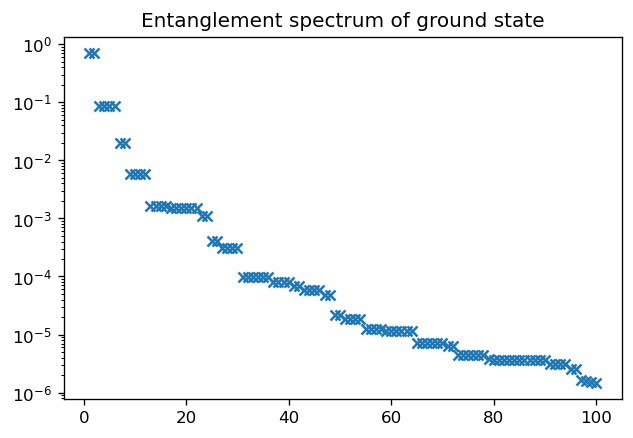

In [29]:
_, S, _ = svd(C) # singular values of center matrix give entanglement spectrum
plt.figure(dpi=120)
plt.title('Entanglement spectrum of ground state')
plt.scatter(np.arange(D)+1, S, marker='x')
plt.yscale('log')
plt.show()

We can clearly see that the entanglement spectrum consists of degenerate groups, which reflects an underlying symmetry in the ground state of the spin-1 Heisenberg antiferromagnet.